In [1]:
'''
Xola Ndaliso 
Implementation of Metropolis-Hastings algorithm 
to constrain cosmological parameters 
H and Lambda
'''

import numpy as np
import pylab as pl
from scipy.integrate import quad, trapz

z, mu, mu_err = [], [], []

with open('SCPUnion2_mu_vs_z.txt', 'r') as scp:
    for _ in range(5):
        next(scp)
    for line in scp:
        z.append(float(line.split()[1]))
        mu.append(float(line.split()[2]))
        mu_err.append(float(line.split()[3]))
        
z, mu, mu_err = np.array(z), np.array(mu), np.array(mu_err)
mu_err = mu_err**2 + 0.12**2              #adding an intrinsic scatter of 0.12

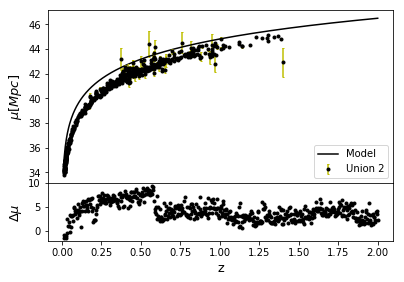

In [2]:
z_new = np.linspace(0.01, 2, 557)  #new redshift array
H_0 = 70
om_m = 0.3
c = 3.0e+5

D_L = (2*c/(H_0*np.sqrt(om_m)))*((1 + z_new) - (1 + z_new)**(0.5))  #luminosity distance relation
d_mod = 5*np.log10(D_L) + 25        #calculating the distance modulus


fig1 = pl.figure(1)
fr1 = fig1.add_axes((.1, .3, 0.8, .6))
pl.plot(z_new, d_mod, 'k-', label = 'Model')   #plotting the model
pl.errorbar(z, mu, yerr = mu_err, fmt = 'k.', ecolor = 'y', capsize = 0.9, label = 'Union 2') #plotting SNIa data
pl.ylabel('$\mu [Mpc]$', fontsize = 13)
pl.legend()
fr1.set_xticklabels([]) #Remove x-tic labels for the first frame

residual = d_mod - mu
fr2 = fig1.add_axes((.1, .1, 0.8, .2))        #setting the frame axes
pl.plot(z_new, residual,'k.')
pl.xlabel('z', fontsize = 13)
pl.ylabel('$\Delta \mu$', fontsize = 13)
pl.savefig('mod_dat.eps', format = 'eps', dpi = 150)
pl.show()

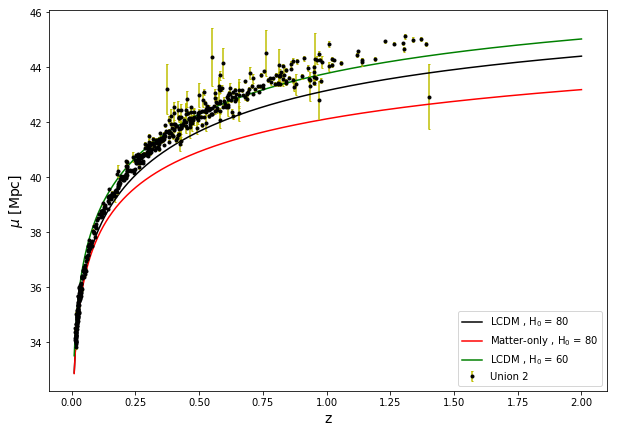

In [3]:
def cosmo_model(z, n):   #function with all the Cosmological 
    
    if n == 0:
        H_0, om_m, om_l = 80, 0.3, 0.7    #LCDM model
        return c/(H_0*np.sqrt((om_m*(1 + z)**3) + om_l))
    if n == 1:
        H_0, om_m = 80, 1
        return c/(H_0*np.sqrt(om_m*(1 + z)**3))
    else:
        H_0, om_m, om_l = 60, 0.3, 0.7    #LCDM model
        return c/(H_0*np.sqrt((om_m*(1 + z)**3) + om_l))

def dL(f, z):          #to compute the luminosity-distance 
    
    integ = quad(lambda x: f, 0, z)[0]
    return integ*(1 + z)

cl, lbls, H = ['k', 'r', 'g'], ['LCDM', 'Matter-only', 'LCDM'], [80, 80, 60]
pl.figure(figsize = (10, 7))

mu_lst = [[] for _ in range(3)]
for i in range(3):
    for j in range(len(z_new)):
        dl = dL(cosmo_model(z_new[j], i), z_new[j])
        d_modulus = 5*np.log10(dl) + 25
        mu_lst[i].append(d_modulus)
    pl.plot(z_new, mu_lst[i], str(cl[i])+'-', label = str(lbls[i])+' , ' + 'H$_0$ ='+ ' ' +str(H[i]))
pl.errorbar(z, mu, yerr = mu_err, fmt = 'k.', ecolor = 'y', capsize = 0.9, label = 'Union 2')
pl.legend()
pl.xlabel('z', fontsize = 14)
pl.ylabel('$\mu$ [Mpc]', fontsize = 14)
pl.show()

In [ ]:
def d_mod(z, params):           
     #to compute the luminosity-distance
     #params[0] = H0 and params[1] = omega-DE
    c = 3.0e+5                   #speed of light in km/s
    
    gg = np.zeros(len(z))
    for i in range(len(z)):
        
        integ = quad(lambda x: c/(params[0]*np.sqrt((1 - params[1])*(1 + x)**3 + params[1])), 0, z[i])[0]   
        dl = integ*(1 + z[i])
        gg[i] = 5*np.log10(dl) + 25
        
    return gg  

def Likelihood(x, d_mod):
    
    #function to calculate the Likelihood
    #chosen as the pdf of a normal distribution i.e the proposal distribution
    
    chi_sq = np.sum(((x - d_mod)**2)/d_mod)

    return np.exp(-chi_sq/2) 

def Ratio(x, mu_new, mu):
    
    #function to calculate the ratio of the new posterior to the current one
    
        P_new = Likelihood(x, mu_new)
        P_current = Likelihood(x, mu)
        
        return P_new/P_current

H0, om_l = 70, 0.7    #initial values for H0 and omega-DE

file = open('parameters.txt', 'w')
file.write('%3s %3s %3s %3s\n' %( '#', 'i', 'H0', 'omega-DE'))
H, omega = [], []

#MCMC implementation

for i in range(50000):
    
    params, sig = [H0, om_l], [0.09, .001]   #initial guesses for H0 and omege-DE and the guessed values of sig
    d_mod0 = d_mod(z, params)                #current value of mu
    
    delt_H0 = np.random.normal(params[0], sig[0])          #drawing H0 proposal from a uniform distribution
    delt_om_l = np.random.normal(params[1], sig[1])        #drawing omega-DE proposal from a uniform distribution
    
    H1, om_l1 =  delt_H0, delt_om_l               #new value of H0 and omega-DE
    params_new = [H1, om_l1]                      #new list of parameters
    
    d_mod1 = d_mod(z, params_new)                 #new value of mu, calculated from H1 and new omega-DE
    
    if H1 >= 50 and H1 <= 85 and om_l1 >= 0.3 and om_l1 <= 0.75: 
               
            R = Ratio(mu, d_mod1, d_mod0)

            r = np.random.uniform(0, 1)                      #r value from a standard gaussian

            if r < R:
                H0, om_l = H1, om_l1

            else:
                H0, om_l = H0, om_l

            H.append(H0)
            omega.append(om_l)

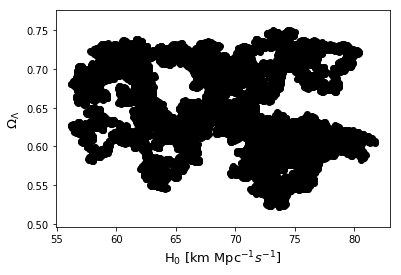

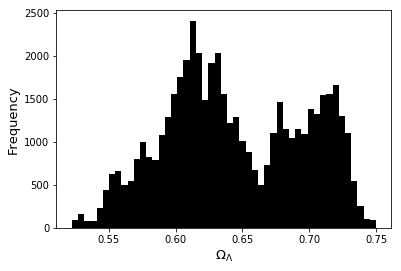

In [146]:
pl.scatter(H, omega, c = 'k')
pl.xlabel('H$_0$ [km Mpc$^{-1} s^{-1}$]', fontsize = 13)
pl.ylabel('$\Omega_{\Lambda}$',  fontsize = 13)
pl.show()
pl.hist(omega, color = 'k', bins = 'auto')
pl.xlabel('$\Omega_{\Lambda}$',  fontsize = 13)
pl.ylabel('Frequency',  fontsize = 13)
pl.show()